In [7]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

In [8]:
def sample_batch(batch_size, device='cpu'):

    data, _ = make_swiss_roll(batch_size)
    data = data[:, [2,0]] / 10
    data = data *np.array([1, -1])
    return torch.from_numpy(data).to(device)

In [9]:
class MLP(nn.Module):

    def __init__(self, N=40, data_dim=2, hidden_dim=64):
        super(MLP, self).__init__()

        self.network_head = nn.Sequential(nn.Linear(data_dim, hidden_dim),
                                          nn.ReLU(),
                                          nn.Linear(hidden_dim, hidden_dim),
                                          nn.ReLU(),)
        
        self.network_tail = nn.ModuleList([nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                                         nn.ReLU(),
                                                         nn.Linear(hidden_dim, data_dim * 2),) for t in range(N)])
        

    def forward(self, x, t):

        h = self.network_head(x) # [batch_size, hidden_dim]
        tmp = self.network_tail[t](h) # [batch_size, data_dim * 2]
        mu, h = torch.chunk(tmp, 2, dim=1)
        var = torch.exp(h)
        std = torch.sqrt(var)

        return mu, std

In [10]:
model = torch.load('model_paper1')
t = 5
x = torch.randn((64, 2))
mu, std = model(x, t)

print(mu.shape)
print(std.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'model_paper1'

In [11]:
class DiffusionModel():
    def __init__(self, T, model: nn.Module):
        self.betas = torch.sigmoid(torch.linspace(-18, 10, T)) * (3e-1 - 1e-5) + 1e-5 # scaling data
        self.alphas = 1-self.betas
        self.alphas_bar = torch.cumprod(self.alphas, 0)

        self.T = T
        self.model = model


    def forward_process(self, x0, t):

        # param t: Number of diffusion steps
        # param x0: data

        assert t > 0, 't should be greater than 0'
        assert self.T <= self.T, 'T should be lower or equal than {self.T}'

        t = t - 1 # Because we start indexing at 0

        mu = torch.sqrt(self.alphas_bar[t]) * x0
        std = torch.sqrt(1 - self.alphas_bar[t])
        epsilon = torch.randn_like(x0)

        return mu + epsilon * std # data ~ N(mu, std)
    
    def reverse_process(self, xt, t):

        # param t: Number of diffusion steps
        # param x0: data

        assert t > 0, 't should be greater than 0'
        assert self.T <= self.T, 'T should be lower or equal than {self.T}'

        t = t - 1 # Because we start indexing at 0

        mu, std = self.model(xt, t)
        epsilon = torch.randn_like(x0)

        return mu + epsilon * std # data ~ N(mu, std)



       

In [12]:
x0 = sample_batch(5_000)
model = DiffusionModel(40, model)
xT = model.forward_process(x0, 20)

In [13]:
print(xT.mean(0))
print(xT.std(0))

tensor([ 0.0177, -0.2143], dtype=torch.float64)
tensor([0.7006, 0.6675], dtype=torch.float64)


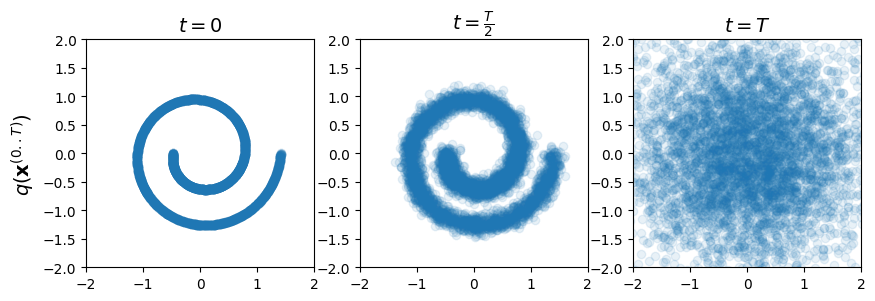

In [14]:
font_size = 14
fig = plt.figure(figsize=(10, 3))

data = [x0, model.forward_process(x0, 20), model.forward_process(x0, 40)]
for i in range(3):

    plt.subplot(1, 3, 1+i)
    plt.scatter(data[i][:, 0].data.numpy(), data[i][:, 1].data.numpy(), alpha=0.1)
    plt.xlim([-2,2])
    plt.ylim([-2,2])
    plt.gca().set_aspect('equal')

    if i == 0:
        plt.ylabel(r'$q(\mathbf{x}^{(0..T)})$', fontsize = font_size)
        plt.title(r'$t=0$', fontsize = font_size)
    elif i == 1:
        plt.title(r'$t=\frac{T}{2}$', fontsize = font_size)
    elif i == 2:
        plt.title(r'$t=T$', fontsize = font_size)

plt.savefig('forward_process.png', bbox_inches = 'tight')